# Preprocessing

In [13]:
import librosa
import numpy as np

def preprocess_audio(audio_path, sample_rate=16000):
    """
    Vorverarbeitung einer Audiodatei: Resampling und Normalisierung.

    Args:
        audio_path (str): Pfad zur Audiodatei.
        sample_rate (int): Ziel-Sampling-Rate (Standard: 16000).

    Returns:
        np.array: Das vorverarbeitete Audio-Signal.
    """
    # Audiodatei laden und resamplen
    audio_signal, _ = librosa.load(audio_path, sr=sample_rate)

    # Zu Mono konvertieren (falls mehrkanalig)
    audio_signal = librosa.to_mono(audio_signal)

    # Normalisieren
    max_val = np.max(np.abs(audio_signal))
    if max_val > 0:
        audio_signal = audio_signal / max_val

    return audio_signal

# Estimate SNR

In [14]:
# Funktion zur adaptiven SNR-Berechnung
def calculate_snr_adaptive(audio_signal, sample_rate=16000, frame_length=0.025, percent_low_energy=0.1):
    """
    Berechnet das Signal-Rausch-Verhältnis (SNR) basierend auf spektraler Analyse,
    wobei die leisesten Frames zur Rauschabschätzung genutzt werden.
    """
    frame_size = int(frame_length * sample_rate)
    hop_size = frame_size // 2  # 50% Überlappung

    num_frames = (len(audio_signal) - frame_size) // hop_size + 1
    if num_frames < 1:
        return np.nan  # Falls zu wenig Daten vorhanden sind, NaN zurückgeben

    frames = np.array([audio_signal[i * hop_size:i * hop_size + frame_size] for i in range(num_frames)])
    frame_energies = np.mean(frames ** 2, axis=1)

    num_noise_frames = max(1, int(len(frame_energies) * percent_low_energy))
    noise_frame_indices = np.argsort(frame_energies)[:num_noise_frames]
    noise_segment = np.concatenate([frames[i] for i in noise_frame_indices])

    _, psd_signal = welch(audio_signal, fs=sample_rate, nperseg=1024)
    _, psd_noise = welch(noise_segment, fs=sample_rate, nperseg=1024)

    signal_power = np.mean(psd_signal)
    noise_power = np.mean(psd_noise)

    if noise_power == 0:
        return 100.0  # Kein Rauschen erkannt

    return 10 * np.log10(signal_power / noise_power)

# Common Voice

## cv-corpus-18.0-delta-2024-06-14

/var/folders/20/0f1z0fvn1hvgz14x2k0l0zz00000gn/T/ipykernel_1870/2757078362.py:30: RuntimeWarning: overflow encountered in scalar divide
  return 10 * np.log10(signal_power / noise_power)


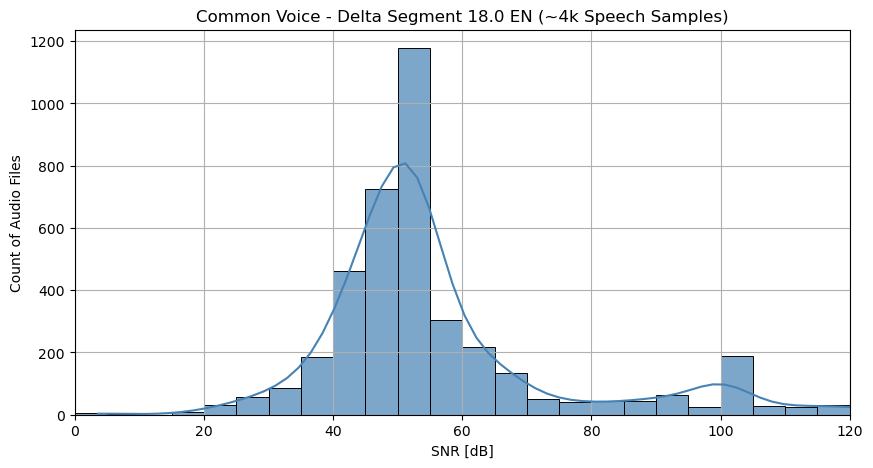


Statistics:
count    4025.000000
mean       57.846933
std        23.975189
min         3.567589
25%        46.218510
50%        51.795994
75%        59.167435
max       368.036957
Name: snr, dtype: float64


In [15]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

# Neues Verzeichnis mit den .flac-Dateien (Pfad anpassen)
audio_dir = "../../audio_files/cv-corpus-18.0-delta-2024-06-14"

# Liste zur Speicherung der SNR-Werte
snr_results = []

# Rekursive Suche nach .flac-Dateien in Unterverzeichnissen
for root, _, files in os.walk(audio_dir):
    for file_name in files:
        if file_name.endswith(".mp3"):  # Nur .flac-Dateien verarbeiten
            file_path = os.path.join(root, file_name)

            # Preprocessing der Datei
            audio_signal = preprocess_audio(file_path)

            # Berechnung des SNRs
            snr_value = calculate_snr_adaptive(audio_signal)

            # Speichern der Ergebnisse
            snr_results.append({"filename": file_name, "snr": snr_value})

# DataFrame erstellen
snr_df = pd.DataFrame(snr_results)

# Bereinigung von NaN- und Inf-Werten
snr_df = snr_df.replace([np.inf, -np.inf], np.nan).dropna()

# Statistik der SNR-Werte
snr_statistics = snr_df["snr"].describe()

# Histogramm der SNR-Werte mit KDE
plt.figure(figsize=(10, 5))
bins = np.arange(0, 121, 5)  # Bins von 0 bis 120 dB in 5-dB-Schritten
sns.histplot(snr_df["snr"], bins=bins, kde=True, color="steelblue", alpha=0.7)
plt.xlabel("SNR [dB]")
plt.ylabel("Count of Audio Files")
plt.title("Common Voice - Delta Segment 18.0 EN (~4k Speech Samples)")
#plt.title("Verteilung der SNR-Werte nach adaptiver Berechnung")
plt.xlim(0, 120)  # Begrenzung auf 0 bis 120 dB
plt.grid()
plt.show()

# Ergebnisse anzeigen
print("\nStatistics:")
print(snr_statistics)

## cv-corpus-20.0-2024-12-06

/opt/homebrew/Caskroom/miniconda/base/envs/ma-env/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 800, using nperseg = 800
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/var/folders/20/0f1z0fvn1hvgz14x2k0l0zz00000gn/T/ipykernel_1870/2757078362.py:30: RuntimeWarning: overflow encountered in scalar divide
  return 10 * np.log10(signal_power / noise_power)
/opt/homebrew/Caskroom/miniconda/base/envs/ma-env/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 400, using nperseg = 400
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/homebrew/Caskroom/miniconda/base/envs/ma-env/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 768, using nperseg = 768
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


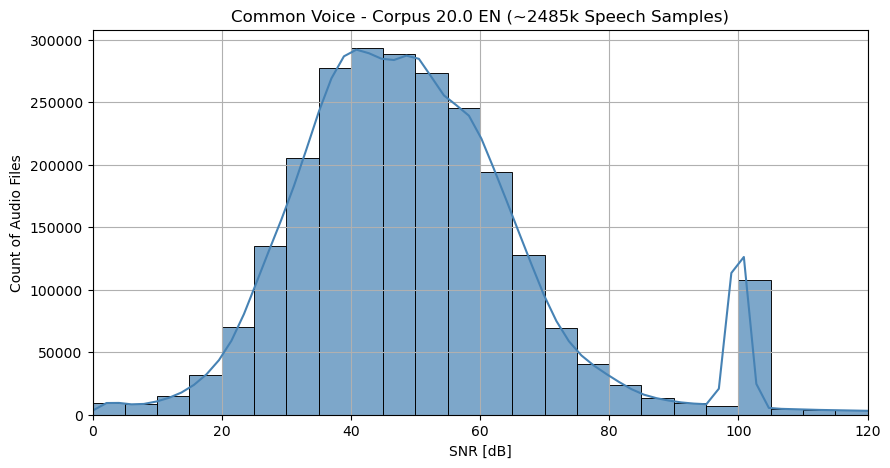


Statistics:
count    2.485051e+06
mean     5.202361e+01
std      2.633468e+01
min      2.231069e-01
25%      3.775391e+01
50%      4.844074e+01
75%      6.023932e+01
max      3.853144e+02
Name: snr, dtype: float64


In [16]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

# Neues Verzeichnis mit den .flac-Dateien (Pfad anpassen)
audio_dir = "../../audio_files/cv-corpus-20.0-2024-12-06"

# Liste zur Speicherung der SNR-Werte
snr_results = []

# Rekursive Suche nach .flac-Dateien in Unterverzeichnissen
for root, _, files in os.walk(audio_dir):
    for file_name in files:
        if file_name.endswith(".mp3"):  # Nur .flac-Dateien verarbeiten
            file_path = os.path.join(root, file_name)

            # Preprocessing der Datei
            audio_signal = preprocess_audio(file_path)

            # Berechnung des SNRs
            snr_value = calculate_snr_adaptive(audio_signal)

            # Speichern der Ergebnisse
            snr_results.append({"filename": file_name, "snr": snr_value})

# DataFrame erstellen
snr_df = pd.DataFrame(snr_results)

# Bereinigung von NaN- und Inf-Werten
snr_df = snr_df.replace([np.inf, -np.inf], np.nan).dropna()

# Statistik der SNR-Werte
snr_statistics = snr_df["snr"].describe()

# Histogramm der SNR-Werte mit KDE
plt.figure(figsize=(10, 5))
bins = np.arange(0, 121, 5)  # Bins von 0 bis 120 dB in 5-dB-Schritten
sns.histplot(snr_df["snr"], bins=bins, kde=True, color="steelblue", alpha=0.7)
plt.xlabel("SNR [dB]")
plt.ylabel("Count of Audio Files")
plt.title("Common Voice - Corpus 20.0 EN (~2485k Speech Samples)")
#plt.title("Verteilung der SNR-Werte nach adaptiver Berechnung")
plt.xlim(0, 120)  # Begrenzung auf 0 bis 120 dB
plt.grid()
plt.show()

# Ergebnisse anzeigen
print("\nStatistics:")
print(snr_statistics)

# Librispeech

## Train Clean 100

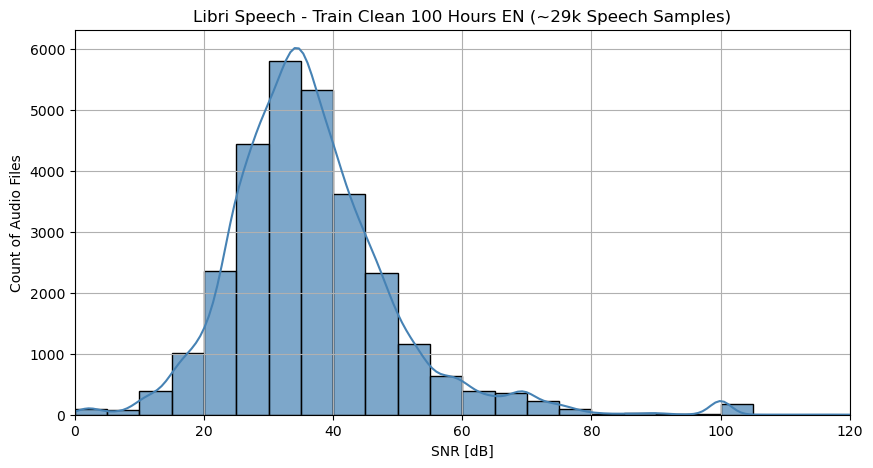


Statistics:
count    28539.000000
mean        36.620604
std         12.736097
min          0.143353
25%         28.772075
50%         35.109314
75%         42.417915
max        132.431000
Name: snr, dtype: float64


In [17]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

# Neues Verzeichnis mit den .flac-Dateien (Pfad anpassen)
audio_dir = "../../audio_files/libri-train-clean-100"

# Liste zur Speicherung der SNR-Werte
snr_results = []

# Rekursive Suche nach .flac-Dateien in Unterverzeichnissen
for root, _, files in os.walk(audio_dir):
    for file_name in files:
        if file_name.endswith(".flac"):  # Nur .flac-Dateien verarbeiten
            file_path = os.path.join(root, file_name)

            # Preprocessing der Datei
            audio_signal = preprocess_audio(file_path)

            # Berechnung des SNRs
            snr_value = calculate_snr_adaptive(audio_signal)

            # Speichern der Ergebnisse
            snr_results.append({"filename": file_name, "snr": snr_value})

# DataFrame erstellen
snr_df = pd.DataFrame(snr_results)

# Bereinigung von NaN- und Inf-Werten
snr_df = snr_df.replace([np.inf, -np.inf], np.nan).dropna()

# Statistik der SNR-Werte
snr_statistics = snr_df["snr"].describe()

# Histogramm der SNR-Werte mit KDE
plt.figure(figsize=(10, 5))
bins = np.arange(0, 121, 5)  # Bins von 0 bis 120 dB in 5-dB-Schritten
sns.histplot(snr_df["snr"], bins=bins, kde=True, color="steelblue", alpha=0.7)
plt.xlabel("SNR [dB]")
plt.ylabel("Count of Audio Files")
plt.title("Libri Speech - Train Clean 100 Hours EN (~29k Speech Samples)")
#plt.title("Verteilung der SNR-Werte nach adaptiver Berechnung")
plt.xlim(0, 120)  # Begrenzung auf 0 bis 120 dB
plt.grid()
plt.show()

# Ergebnisse anzeigen
print("\nStatistics:")
print(snr_statistics)

## Dev Other

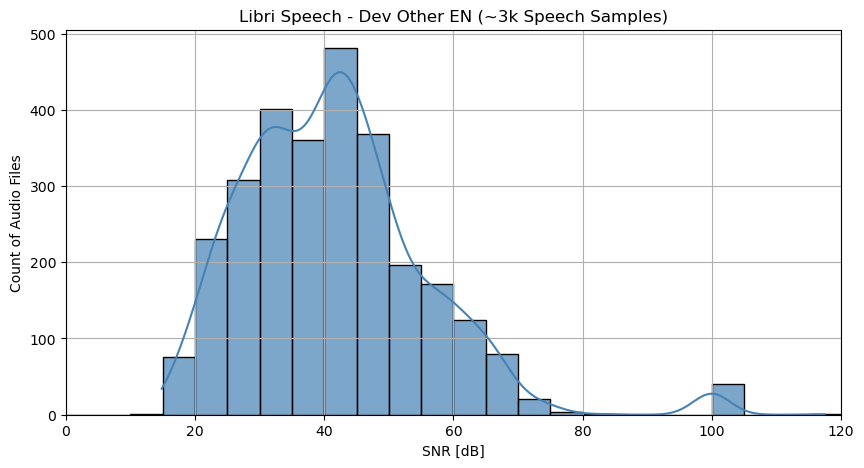


Statistics:
count    2864.000000
mean       41.450211
std        14.196278
min        14.834377
25%        31.216153
50%        40.742304
75%        48.829653
max       117.482140
Name: snr, dtype: float64


In [18]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

# Neues Verzeichnis mit den .flac-Dateien (Pfad anpassen)
audio_dir = "../../audio_files/libri-dev-other"

# Liste zur Speicherung der SNR-Werte
snr_results = []

# Rekursive Suche nach .flac-Dateien in Unterverzeichnissen
for root, _, files in os.walk(audio_dir):
    for file_name in files:
        if file_name.endswith(".flac"):  # Nur .flac-Dateien verarbeiten
            file_path = os.path.join(root, file_name)

            # Preprocessing der Datei
            audio_signal = preprocess_audio(file_path)

            # Berechnung des SNRs
            snr_value = calculate_snr_adaptive(audio_signal)

            # Speichern der Ergebnisse
            snr_results.append({"filename": file_name, "snr": snr_value})

# DataFrame erstellen
snr_df = pd.DataFrame(snr_results)

# Bereinigung von NaN- und Inf-Werten
snr_df = snr_df.replace([np.inf, -np.inf], np.nan).dropna()

# Statistik der SNR-Werte
snr_statistics = snr_df["snr"].describe()

# Histogramm der SNR-Werte mit KDE
plt.figure(figsize=(10, 5))
bins = np.arange(0, 121, 5)  # Bins von 0 bis 120 dB in 5-dB-Schritten
sns.histplot(snr_df["snr"], bins=bins, kde=True, color="steelblue", alpha=0.7)
plt.xlabel("SNR [dB]")
plt.ylabel("Count of Audio Files")
plt.title("Libri Speech - Dev Other EN (~3k Speech Samples)")
#plt.title("Verteilung der SNR-Werte nach adaptiver Berechnung")
plt.xlim(0, 120)  # Begrenzung auf 0 bis 120 dB
plt.grid()
plt.show()

# Ergebnisse anzeigen
print("\nStatistics:")
print(snr_statistics)

In [2]:
import matplotlib.pyplot as plt

plt.gcf().savefig("mein_plot.png", dpi=300, bbox_inches="tight")  # Letzten Plot speichern

<Figure size 640x480 with 0 Axes>